In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from botorch.test_functions import Branin
import pandas as pd

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

In [4]:
import sys
import os

sys.path.append(os.path.abspath('../src'))

In [5]:
from fixed_noise_gp import get_gp, train_gp, predict

In [6]:
torch.manual_seed(42)

In [7]:
# Branin function
branin = Branin(negate=False)

# Radial sigma(x)
def sigma_radial(x):
    center = torch.tensor([2.5, 7.5], device=x.device)
    radius = torch.norm(x - center, dim=-1)
    max_radius = torch.sqrt(torch.tensor(2.0)) / 2
    return 0.1 + 0.4 * (radius / max_radius)

def plot(ax, data, title):
    c = ax.contourf(x1_np, x2_np, data, levels=50)
    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    fig.colorbar(c, ax=ax)

In [8]:
x1_vals = torch.linspace(-5, 10, 31)
x2_vals = torch.linspace(0, 15, 31)
x1_grid, x2_grid = torch.meshgrid(x1_vals, x2_vals, indexing='ij')
x = torch.stack([x1_grid.reshape(-1), x2_grid.reshape(-1)], dim=-1)

In [9]:
f_x = branin(x)
sigma_x = sigma_radial(x)

lam = 5.0
noise = lam * sigma_x * torch.randn_like(f_x)
F_x = f_x + noise

In [10]:
f_x_grid = f_x.reshape(31, 31).numpy()
sigma_x_grid = sigma_x.reshape(31, 31).numpy()
noise_grid = noise.reshape(31, 31).numpy()
F_x_grid = F_x.reshape(31, 31).numpy()
x1_np = x1_grid.numpy()
x2_np = x2_grid.numpy()

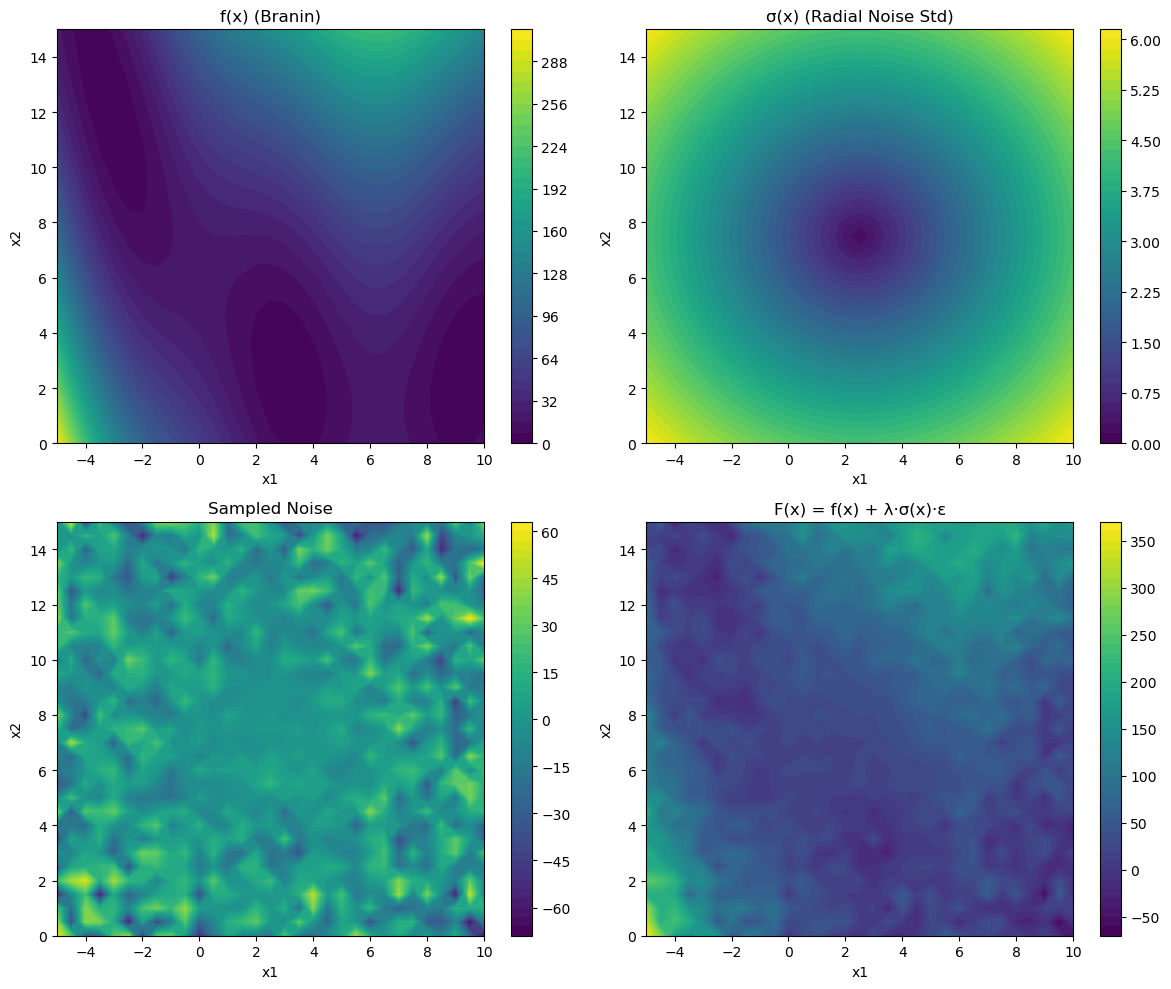

In [11]:
# Plot
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
plot(axs[0, 0], f_x_grid, "f(x) (Branin)")
plot(axs[0, 1], sigma_x_grid, "σ(x) (Radial Noise Std)")
plot(axs[1, 0], noise_grid, "Sampled Noise")
plot(axs[1, 1], F_x_grid, "F(x) = f(x) + λ·σ(x)·ε")

plt.tight_layout()
plt.show()

In [12]:
y = F_x.unsqueeze(-1)
yvar = (lam * sigma_x).pow(2).unsqueeze(-1)

In [13]:
perm = torch.randperm(x.shape[0])
train_idx = perm[:25]
test_idx = perm[25:]

In [14]:
train_x = x[train_idx]
train_y = y[train_idx]
# train_yvar = yvar[train_idx]

test_x = x[test_idx]
test_y = y[test_idx]
# test_yvar = yvar[test_idx]

In [15]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler(feature_range=(-1, 1))),
    ('model', RandomForestRegressor())
])

In [16]:
param_grid = {
    'model__n_estimators': [50, 100, 200, 500],
    'model__max_depth': [None, 10, 20, 50],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['auto', 'sqrt'],
    'model__bootstrap': [True, False],                  
}

In [17]:
model = RandomizedSearchCV(
    pipe, 
    param_grid,
    n_iter=100,
    refit=True, 
    verbose=0, 
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=RepeatedKFold(n_splits=5, n_repeats=5)
)

In [18]:
model.fit(train_x, train_y)

RandomizedSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=5, random_state=None),
                   estimator=Pipeline(steps=[('scaler',
                                              MinMaxScaler(feature_range=(-1,
                                                                          1))),
                                             ('model',
                                              RandomForestRegressor())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'model__bootstrap': [True, False],
                                        'model__max_depth': [None, 10, 20, 50],
                                        'model__max_features': ['auto', 'sqrt'],
                                        'model__min_samples_leaf': [1, 2, 4],
                                        'model__min_samples_split': [2, 5, 10],
                                        'model__n_estimators': [50, 100, 200,
                                                                500]},
                   scoring='neg_mean_squared_error')

In [19]:
best_pipe = model.best_estimator_

In [20]:
print(model.best_params_)

{'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 20, 'model__bootstrap': False}


In [21]:
test_x_scaled = best_pipe.named_steps['scaler'].transform(test_x)

rf_model = best_pipe.named_steps['model']

pred_all = np.stack([tree.predict(test_x_scaled) for tree in rf_model.estimators_], axis=0)

pred_mean = np.mean(pred_all, axis=0)
pred_std = np.std(pred_all, axis=0)

In [22]:
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(test_y, pred_mean)
rmse = np.sqrt(mean_squared_error(test_y, pred_mean))

print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

R²: 0.1660
RMSE: 52.6662


In [23]:
from UQtools import order_sig_and_errors, get_slope_metric, spearman_rank_corr, expected_rho, calibration_curve, calibration_area, plot_calibration_curve, plot_Z_scores, NLL

In [25]:
data = np.column_stack((test_y, pred_mean, pred_std))

df = pd.DataFrame(data, columns=['test_y', 'pred_y', 'uq'])
df['error'] = df['pred_y'] - df['test_y']

In [27]:
df

,test_y,pred_y,uq,error
0,18.623110,24.171451,3.634929,5.548341
1,151.106506,18.714272,24.860027,-132.392234
2,-2.820053,23.414201,7.140927,26.234254
3,54.005527,70.813066,25.802488,16.807538
4,52.004673,71.994922,56.278413,19.990249
...,...,...,...,...
931,137.705444,96.999198,18.327452,-40.706247
932,14.508292,15.366883,16.675559,0.858591
933,104.326279,117.468612,47.835928,13.142334
934,114.691368,12.646101,10.991984,-102.045267


rho_rank = 0.24
rho_rank_sim = 0.66 +/- 0.02
miscalibration area = 0.17
R squared: 0.034904233470306134
intercept: 44.47094325136527
slope: 0.2068288315520881


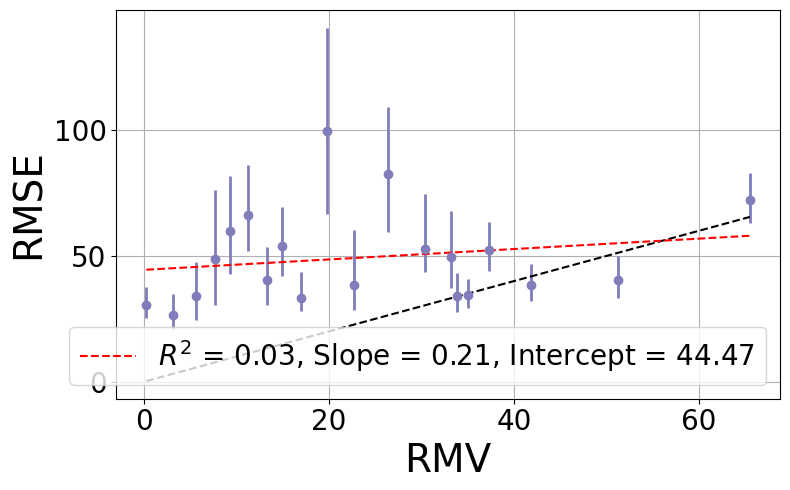

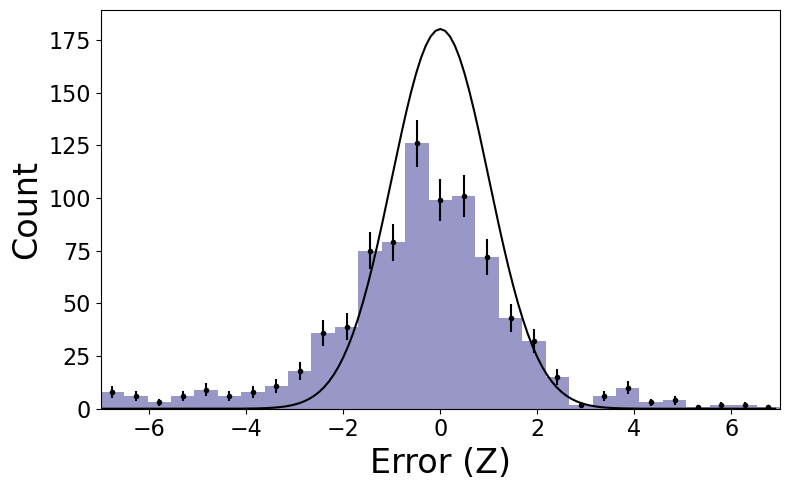

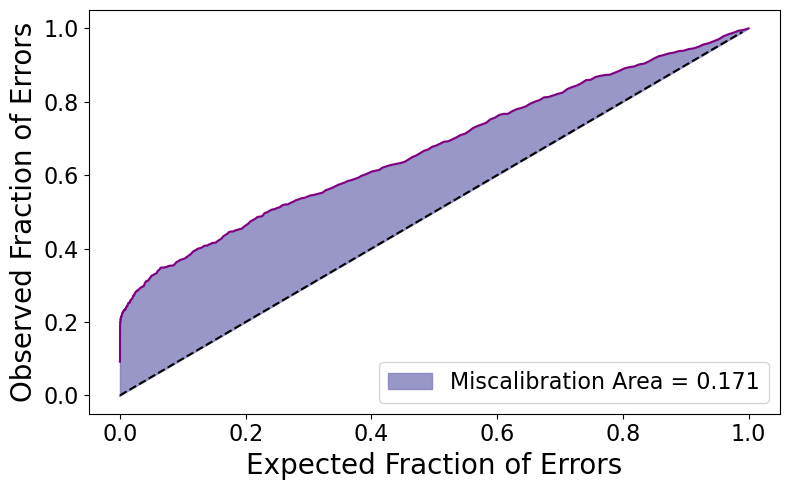

In [28]:
#Order uncertainties and errors according to uncertainties
ordered_df = order_sig_and_errors(df.uq, df.error)

#Calculate rho_rank and rho_rank_sim
rho_rank, _ = spearman_rank_corr(np.abs(df.error), df.uq)
print(f'rho_rank = {rho_rank:.2f}')
exp_rhos_temp = []
for i in range(1000):
    exp_rho, _ = expected_rho(df.uq)
    exp_rhos_temp.append(exp_rho)
rho_rank_sim = np.mean(exp_rhos_temp)
rho_rank_sim_std = np.std(exp_rhos_temp)
print(f'rho_rank_sim = {rho_rank_sim:.2f} +/- {rho_rank_sim_std:.2f}')

#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

# #Calculate NLL and simulated NLL
# _NLL = NLL(df.uq, df.error)
# print(f'NLL = {_NLL:.2f}')
# exp_NLL = []
# for i in range(1000):
#     sim_errors = []
#     for sigma in df.uq:
#         sim_error = np.random.normal(0, sigma)
#         sim_errors.append(sim_error)
#     NLL_sim = NLL(df.uq, sim_errors)
#     exp_NLL.append(NLL_sim)
# NLL_sim = np.mean(exp_NLL)
# NLL_sim_std = np.std(exp_NLL)
# print(f'NLL_sim = {NLL_sim:.2f} +/- {NLL_sim_std:.2f}')

#Generate error-based calibration plot
fig, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

#Generate Z-score plot and calibration curve
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)